# Import Library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Any results you write to the current directory are saved as output.
-import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

C:\Users\hifzhil\miniforge3\envs\tinyml_env\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


# Preparing dataset
This section runs only once to prepare the dataset mouth_state_detection.csv, which will be used throughout the entire session.

In [18]:
def process_images(folder, label):
    data = []
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        if filepath.endswith('.png') or filepath.endswith('.jpg') or filepath.endswith('.jpeg'):
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (28, 28))
                pixel_data = image.flatten()
            data.append(np.insert(pixel_data, 0, label))
    return data

In [19]:
opened_mouth_dir = "C:/Users/hifzh/computer-vision/Mouth-Openess-Detection/dataset/train/Yawn"
closed_mouth_dir = "C:/Users/hifzh/computer-vision/Mouth-Openess-Detection/dataset/train/no_yawn"

## Change the value based on your dataset directory

In [21]:


# Nama folder
opened_data = process_images(opened_mouth_dir, 1)  # 1 for opened mouth
closed_data = process_images(closed_mouth_dir, 0)  # 0 for closed mouth

# Combine the data and convert to a DataFrame
combined_data = np.array(opened_data + closed_data)
df = pd.DataFrame(combined_data)

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

# Set column names
column_names = ['label'] + [f'pixel{i+1}' for i in range(combined_data.shape[1] - 1)]
df.columns = column_names

# Save to CSV
df.to_csv('mouth_state_detection.csv', index=False)


# Data Visualization and Preprocessing

In [2]:
# Load the dataset
dataframe = pd.read_csv("C:/Users/hifzhil/computer-vision/Mouth-Openess-Detection/mouth_state_detection.csv")

In [3]:
dataframe.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,252,250,252,252,252,252,252,252,251,...,47,213,206,130,165,187,220,215,58,68
1,1,146,123,164,180,172,162,157,176,164,...,168,170,173,178,182,171,157,150,154,83
2,1,118,118,120,120,120,121,122,121,120,...,104,105,105,106,108,113,127,138,118,62
3,0,218,209,215,224,225,221,221,224,215,...,161,156,141,127,112,96,89,77,79,71
4,1,143,94,85,97,100,102,91,53,16,...,77,70,116,127,104,143,123,142,109,124
5,0,140,144,144,155,142,122,103,106,99,...,90,91,81,60,36,23,16,9,3,11
6,0,93,91,89,86,87,82,83,80,78,...,109,113,116,116,190,135,204,200,170,118
7,1,198,189,177,162,152,162,168,173,173,...,165,159,136,114,89,61,66,70,64,51
8,1,63,63,63,65,65,65,67,67,68,...,181,183,182,185,187,189,193,194,197,171
9,0,232,219,181,163,125,81,102,110,107,...,198,180,156,141,133,125,124,100,76,72


In [4]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(dataframe, test_size=0.4, random_state=42)  # 40% of data for testing
debug_df = test_df.iloc[:20]
y = test_df['label']


<Axes: xlabel='label', ylabel='count'>

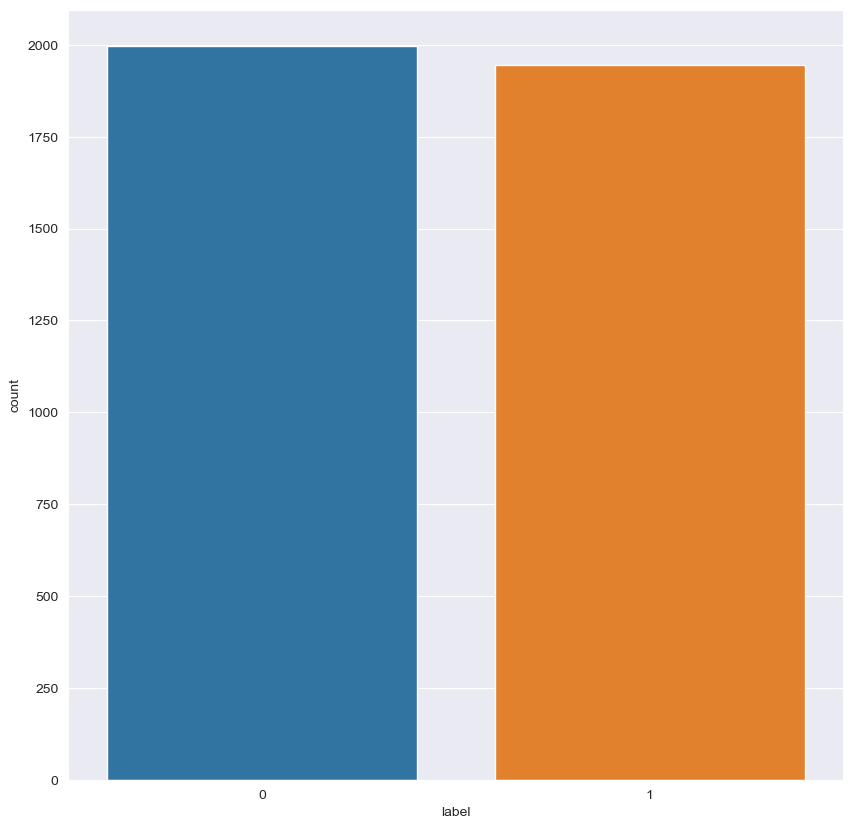

In [5]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df, x = 'label')

<Axes: xlabel='label', ylabel='count'>

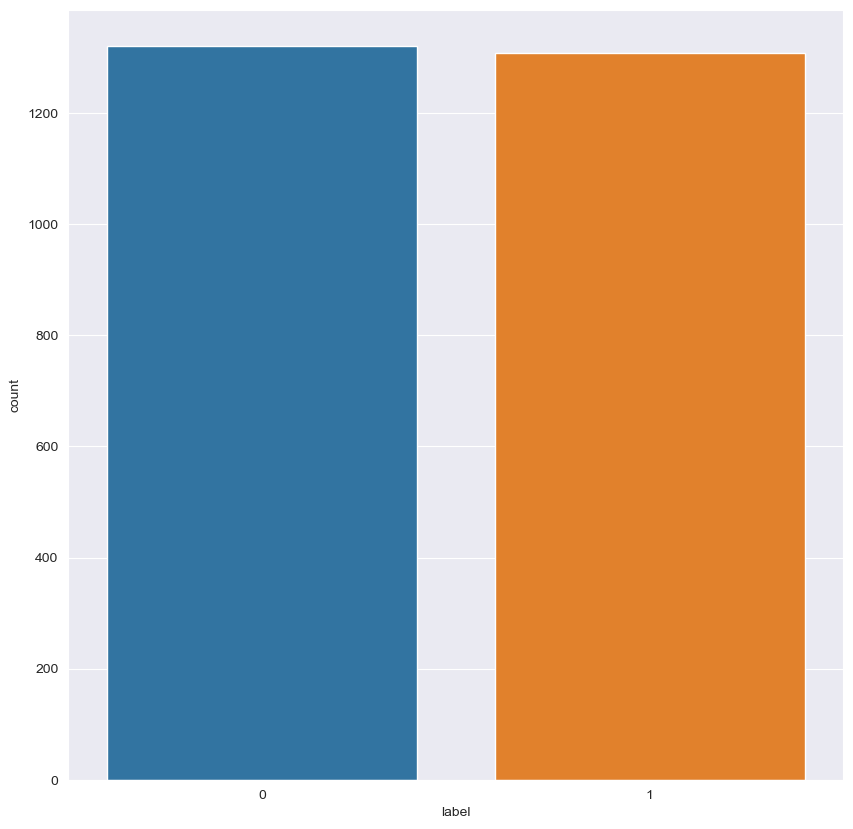

In [6]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(test_df, x = 'label')

In [7]:
y_train = train_df['label']
y_test = test_df['label']

# I put y_debug for degugging in miceocontroller
y_debug = y_test[0:20]

del train_df['label']
del test_df['label']

In [8]:
print(y_train)

3558    0
6150    0
4352    0
2218    0
5137    1
       ..
3772    0
5191    1
5226    0
5390    1
860     0
Name: label, Length: 3942, dtype: int64


In [9]:
y_test.head(20)

5364    1
5586    1
2623    1
5939    0
1360    0
496     0
5409    1
2955    1
2441    0
3442    1
511     1
132     1
3406    1
2927    1
1871    0
3907    1
4768    1
5523    1
4139    0
1452    0
Name: label, dtype: int64

In [10]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)
print(y_train)

[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


In [11]:
x_train = train_df.values
x_test = test_df.values

In [12]:
test_df.head(20)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
5364,49,29,45,45,53,50,63,49,39,35,...,162,152,146,141,111,92,92,109,81,69
5586,183,184,191,188,198,199,203,199,195,188,...,78,85,86,101,110,85,132,145,147,137
2623,113,100,122,187,221,224,217,204,189,194,...,205,197,162,175,136,145,125,120,127,126
5939,142,150,158,161,164,169,164,158,99,85,...,68,108,65,82,125,95,160,161,162,170
1360,165,152,140,130,120,120,136,145,167,173,...,117,111,108,106,106,108,113,122,132,128
496,138,133,118,109,107,101,99,95,87,94,...,138,136,130,127,127,138,11,18,19,28
5409,177,184,191,194,197,200,203,205,206,211,...,107,88,79,72,76,85,77,68,58,19
2955,208,171,142,134,128,120,120,118,121,129,...,162,144,107,109,95,96,115,122,117,118
2441,128,129,128,115,111,112,110,106,94,75,...,205,207,209,205,204,203,202,202,201,190
3442,123,120,108,106,109,104,128,104,107,101,...,102,132,140,99,127,105,110,73,61,64


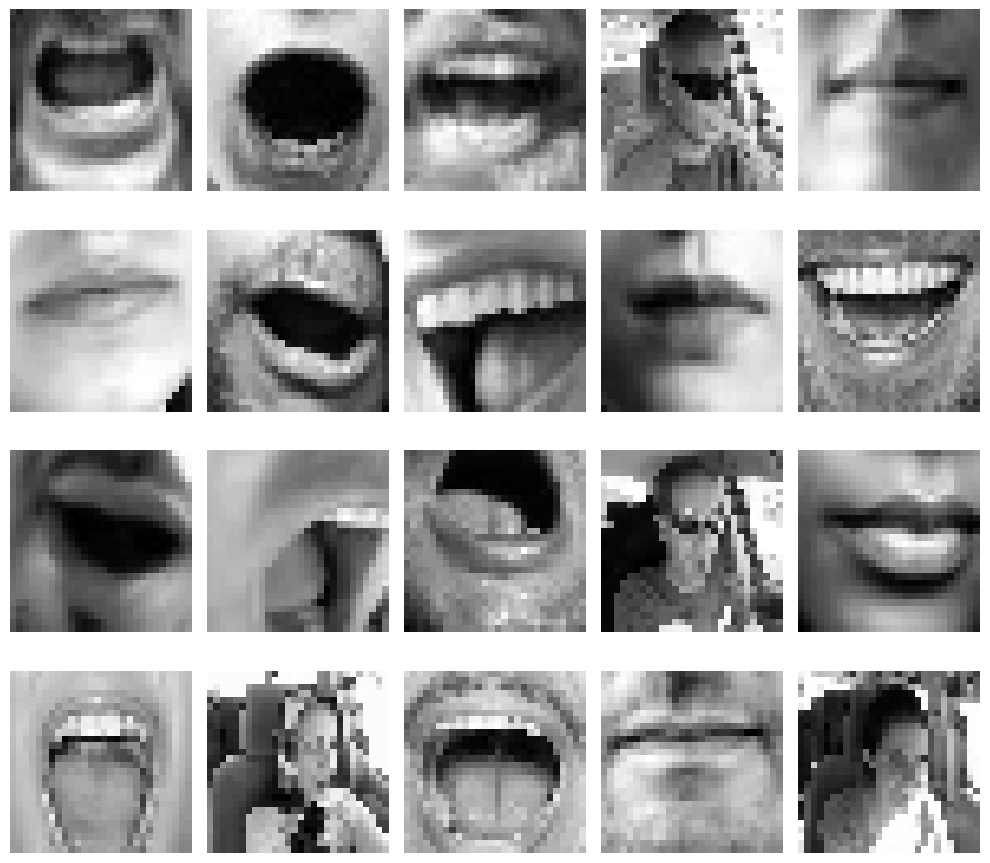

In [13]:
f, ax = plt.subplots(4,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(4):
    for j in range(5):
        img_data = debug_df.iloc[k, 1:].values
        ax[i,j].imshow(img_data.reshape(28, 28) , cmap = "gray")
        ax[i, j].axis('off')
        k += 1
    plt.tight_layout()

# Debugging


In [14]:
#Check the shape of y_debug
np.transpose(y_debug).shape

(20,)

In [15]:
x_debug = (test_df.values)[0:20]
csv_x_debug = 'csv_x.csv'
csv_y_debug = 'csv_y.csv'
y_db2 = np.array(y_debug).reshape(1,-1)
# Write data to the CSV file
np.savetxt(csv_x_debug, x_debug, delimiter=',', fmt='%s')
np.savetxt(csv_y_debug, y_db2, delimiter=',', fmt='%s')

## Normalisasi Data

there are some information that help in the normalization:

- Quantization of 32-bit floating-point data to 8-bit fixedpoint data lowers the model’s memory footprint by 75%, and integer operations make the microcontroller run much faster, i read this on "Tiny Machine Learning for ResourceConstrained Microcontrollers" by Immonen, R., & Hämäläinen
- For 8-bit quantization, int_value is represented by a value in the signed int8 range [-128, 127]. For 16-bit quantization, int_value is represented by a value in the signed int16 range [-32768, 32767]. read : https://docs.espressif.com/projects/esp-dl/en/latest/esp32/tools/quantization-toolkit/quantization-specification.html

So, thats why we need to normalize the data between [-1, 1]

In [16]:
# Normalize the data
x_train = (x_train  / 127.5) - 1.0
x_test = (x_test/127.5)-1.0 # - 128 # / 255

# Normalize the data
# x_train = x_train/255 
# x_test = x_test/255

In [17]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_calibration = x_test[:500]

In [18]:
x_calibration.shape

(500, 28, 28, 1)

In [19]:
np.save('model_calibration.npy', x_calibration.astype(np.float32))

In [20]:
def process_input_npy (x_tmp) :
    x_tmp = np.array(x_tmp)
    return x_tmp

x_tmp_0 = process_input_npy (x_test[0])
x_tmp_1 = process_input_npy (x_test[1])
x_tmp_2 = process_input_npy (x_test[2])
x_tmp_3 = process_input_npy (x_test[3])
x_tmp_4 = process_input_npy (x_test[4])
x_tmp_5 = process_input_npy (x_test[5])
x_tmp_6 = process_input_npy (x_test[6])
x_tmp_7 = process_input_npy (x_test[7])
x_tmp_8 = process_input_npy (x_test[8])
x_tmp_9 = process_input_npy (x_test[9])

x_tmp_10 = process_input_npy (x_test[10])
x_tmp_11 = process_input_npy (x_test[11])
x_tmp_12 = process_input_npy (x_test[12])
x_tmp_13 = process_input_npy (x_test[13])
x_tmp_14 = process_input_npy (x_test[14])
x_tmp_15 = process_input_npy (x_test[15])
x_tmp_16 = process_input_npy (x_test[16])
x_tmp_17 = process_input_npy (x_test[17])
x_tmp_18 = process_input_npy (x_test[18])
x_tmp_19 = process_input_npy (x_test[19])

np.save('./input_img_npy/input_image_0.npy', x_tmp_0.astype(np.float32))
np.save('./input_img_npy/input_image_1.npy', x_tmp_1.astype(np.float32))
np.save('./input_img_npy/input_image_2.npy', x_tmp_2.astype(np.float32))
np.save('./input_img_npy/input_image_3.npy', x_tmp_3.astype(np.float32))
np.save('./input_img_npy/input_image_4.npy', x_tmp_4.astype(np.float32))
np.save('./input_img_npy/input_image_5.npy', x_tmp_5.astype(np.float32))
np.save('./input_img_npy/input_image_6.npy', x_tmp_6.astype(np.float32))
np.save('./input_img_npy/input_image_7.npy', x_tmp_7.astype(np.float32))
np.save('./input_img_npy/input_image_8.npy', x_tmp_8.astype(np.float32))
np.save('./input_img_npy/input_image_9.npy', x_tmp_9.astype(np.float32))

np.save('./input_img_npy/input_image_10.npy', x_tmp_10.astype(np.float32))
np.save('./input_img_npy/input_image_11.npy', x_tmp_11.astype(np.float32))
np.save('./input_img_npy/input_image_12.npy', x_tmp_12.astype(np.float32))
np.save('./input_img_npy/input_image_13.npy', x_tmp_13.astype(np.float32))
np.save('./input_img_npy/input_image_14.npy', x_tmp_14.astype(np.float32))
np.save('./input_img_npy/input_image_15.npy', x_tmp_15.astype(np.float32))
np.save('./input_img_npy/input_image_16.npy', x_tmp_16.astype(np.float32))
np.save('./input_img_npy/input_image_17.npy', x_tmp_17.astype(np.float32))
np.save('./input_img_npy/input_image_18.npy', x_tmp_18.astype(np.float32))
np.save('./input_img_npy/input_image_19.npy', x_tmp_19.astype(np.float32))

In [21]:
#change the input_image_[] and input_data_[] relatively 
def convert_npy_to_header(input_path, output_path, index):
    input_ndarray = np.load(input_path)
    input_dtype = 'float' if input_ndarray.dtype == np.float32 else 'int'
    header_file = os.path.join(output_path, f'input_data_{index}.h')

    # Write the data to the header file
    with open(header_file, 'w') as file:
        file.write('#include <tvmgen_default.h>\n')
        file.write(f'const size_t input_len = {input_ndarray.size};\n')
        file.write(f'const static __attribute__((aligned(16))) {input_dtype} input_data[] = {{')
        file.write(', '.join(map(str, input_ndarray.flatten().tolist())))
        file.write('};\n')

    print(f'Header file "{header_file}" generated successfully.')

def process_directory(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    npy_files = sorted([f for f in os.listdir(input_dir) if f.endswith('.npy')])

    for index, npy_file in enumerate(npy_files):
        input_path = os.path.join(input_dir, npy_file)
        convert_npy_to_header(input_path, output_dir, index)



def convert_npy_to_header(input_path, output_path, index):
    input_ndarray = np.load(input_path)

    input_dtype = 'float' if input_ndarray.dtype == np.float32 else 'int'

    header_file = os.path.join(output_path, f'input_data_{index}.h')

    with open(header_file, 'w') as file:
        file.write('#include <tvmgen_default.h>\n')
        file.write(f'const size_t input_len = {input_ndarray.size};\n')
        file.write(f'const static __attribute__((aligned(16))) {input_dtype} input_data[] = {{')
        file.write(', '.join(map(str, input_ndarray.flatten().tolist())))
        file.write('};\n')

    print(f'Header file "{header_file}" generated successfully.')

def process_directory(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    npy_files = [f for f in os.listdir(input_dir) if f.endswith('.npy')]

    npy_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    for index, npy_file in enumerate(npy_files):
        input_path = os.path.join(input_dir, npy_file)
        convert_npy_to_header(input_path, output_dir, index)

# Define input and output directories
input_dir = 'input_img_npy' 
output_dir = 'input_img_h'

# Process the directory
process_directory(input_dir, output_dir)

Header file "input_img_h\input_data_0.h" generated successfully.
Header file "input_img_h\input_data_1.h" generated successfully.
Header file "input_img_h\input_data_2.h" generated successfully.
Header file "input_img_h\input_data_3.h" generated successfully.
Header file "input_img_h\input_data_4.h" generated successfully.
Header file "input_img_h\input_data_5.h" generated successfully.
Header file "input_img_h\input_data_6.h" generated successfully.
Header file "input_img_h\input_data_7.h" generated successfully.
Header file "input_img_h\input_data_8.h" generated successfully.
Header file "input_img_h\input_data_9.h" generated successfully.
Header file "input_img_h\input_data_10.h" generated successfully.
Header file "input_img_h\input_data_11.h" generated successfully.
Header file "input_img_h\input_data_12.h" generated successfully.
Header file "input_img_h\input_data_13.h" generated successfully.
Header file "input_img_h\input_data_14.h" generated successfully.
Header file "input_i

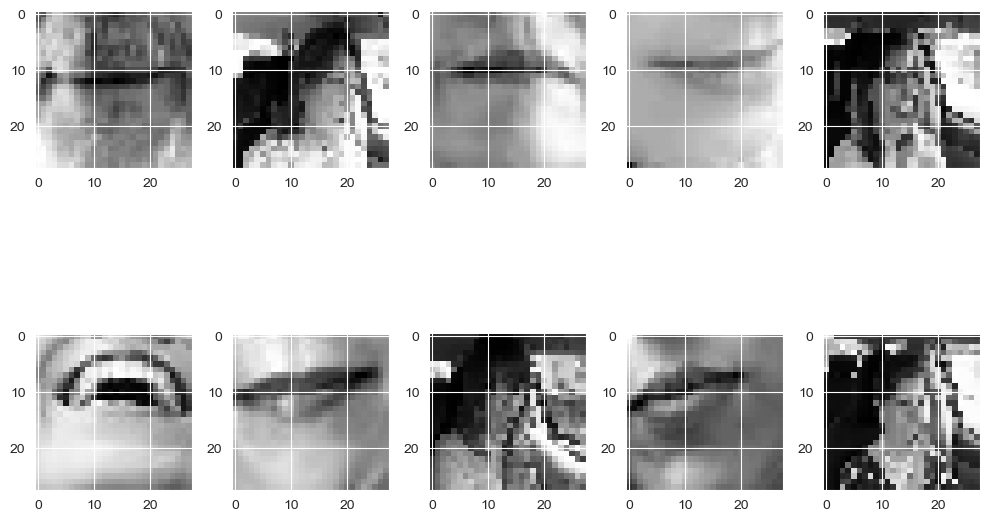

In [22]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()   

# Data Augmentation


In [23]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [24]:
print(datagen)

# Convolutional Neural Network

# Training Network

In [25]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [26]:

# Define the simplest model
model = Sequential()
model.add(Conv2D(65, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(40, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units = 8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


C:\Users\hifzhil\miniforge3\envs\tinyml_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 65)          │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 65)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12740)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │         101,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,587 (400.73 KB)

 Trainable params: 102,587 (400.73 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
#from tensorflow.keras.utils import plot_model

# Plot the model
#plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

In [29]:
history = model.fit(
#    x_train, y_train,  # Ensure x_train is reshaped if needed and y_train is binary
#    batch_size=32,
    datagen.flow(x_train,y_train, batch_size = 128),
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks = [learning_rate_reduction]
)


Epoch 1/20


C:\Users\hifzhil\miniforge3\envs\tinyml_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6175 - loss: 0.6281 - val_accuracy: 0.7241 - val_loss: 0.5293 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7685 - loss: 0.4892 - val_accuracy: 0.7922 - val_loss: 0.4348 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8027 - loss: 0.4321 - val_accuracy: 0.8128 - val_loss: 0.4151 - learning_rate: 0.0010
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8120 - loss: 0.3961 - val_accuracy: 0.8097 - val_loss: 0.4460 - learning_rate: 0.0010
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8235 - loss: 0.3768 - val_accuracy: 0.8269 - val_loss: 0.3805 - learning_rate: 0.0010
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8392 - loss: 0.3438 - val_accuracy: 0.8356 - val_loss: 0.3628 - learning_rate: 0.0010
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8527 - loss: 0.3327 - val_accuracy: 0.83

In [307]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8487 - loss: 0.3116
Accuracy of the model is -  85.12176275253296 %


# Analisis training


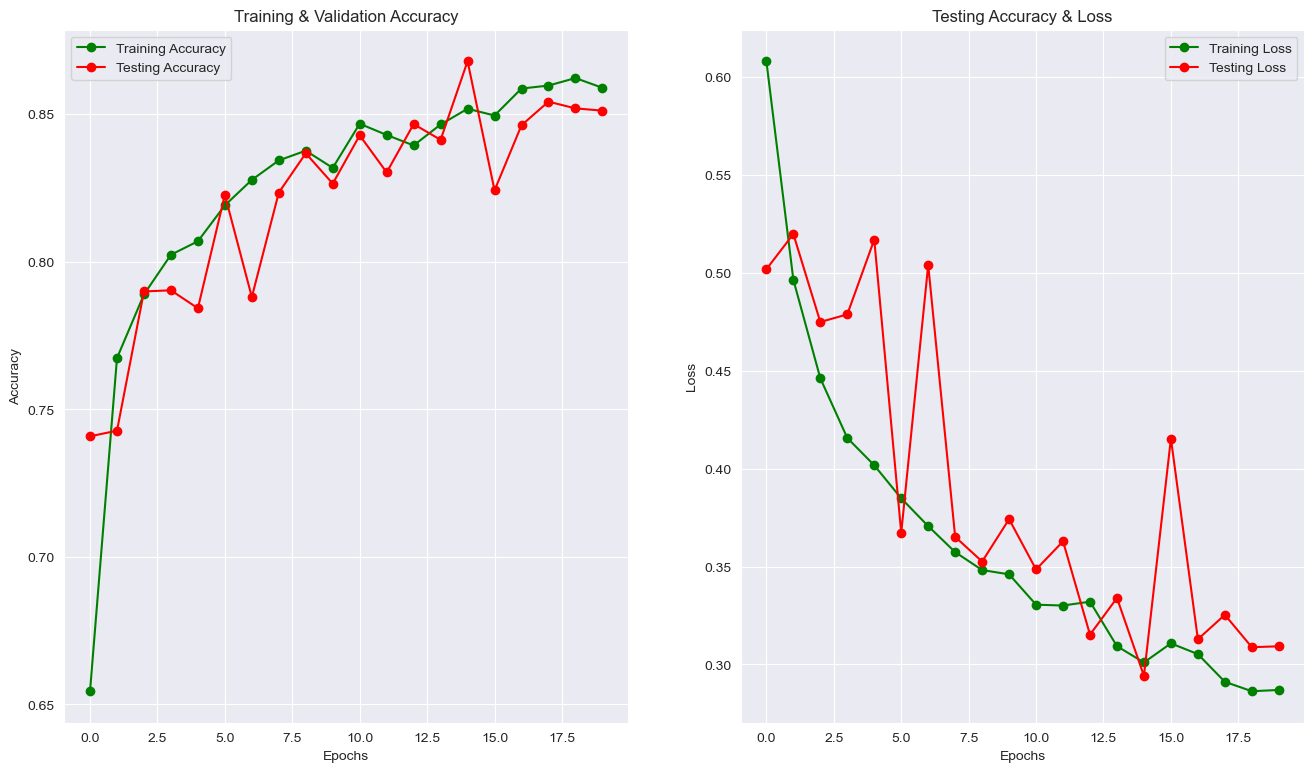

In [308]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [309]:
y_pred = model.predict(x_test)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [310]:
y_pred_binary = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1320
           1       0.80      0.94      0.86      1308

    accuracy                           0.85      2628
   macro avg       0.86      0.85      0.85      2628
weighted avg       0.86      0.85      0.85      2628



In [311]:
cm = confusion_matrix(y_test, y_pred_binary)
print(cm)

[[1014  306]
 [  85 1223]]


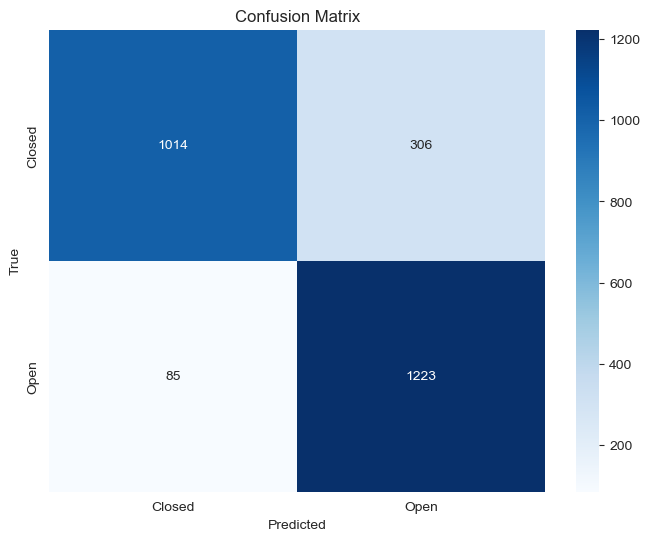

In [312]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [313]:
predictions = np.argmax(y_pred, axis=1)
print(np.array(predictions).shape)
print(y.shape)

(2628,)
(2628,)


In [314]:
correct = np.where(y_pred_binary.flatten() == y_test)[0]
print(correct)

[   0    0    0 ... 2627 2627 2627]


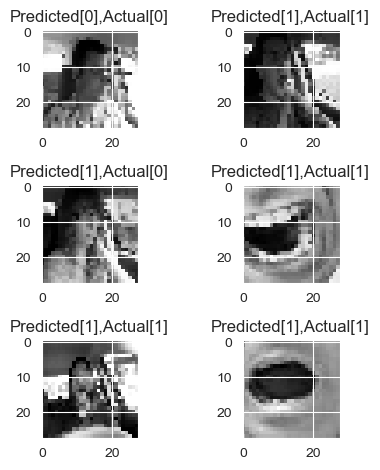

In [315]:
np.random.shuffle(correct)
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted{},Actual{}".format(y_pred_binary[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [316]:
model.save('mode_openess_v1.h5')

# Conversion from Keras to ONNX
Now we know that the keras model is working. We can perform format convertion and reevaluate the model again

In [318]:
import tf2onnx
import onnx

model.output_names = ['output']
input_signature = (tf.TensorSpec((None, 28, 28, 1), tf.float32, name="image_input"),)
onnx_model, _ = tf2onnx.convert.from_keras(model,input_signature, opset=13)
onnx.save(onnx_model, "model_mouth_openness.onnx")

# Evaluate the ONNX Model Performance
I will reevaluate the model read from the ONNX format 

In [112]:
import onnx

# Load the ONNX model
model_onnx = onnx.load('model_mouth_openness.onnx')

# Iterate through each initializer (tensors with values) and print their data type
for tensor in model_onnx.graph.initializer:
    print(f"Tensor {tensor.name} data type: {onnx.TensorProto.DataType.Name(tensor.data_type)}")

# You can also check the data types of inputs and outputs
print("\nInput Tensors:")
for input_tensor in model_onnx.graph.input:
    print(f"Input {input_tensor.name} data type: {input_tensor.type.tensor_type.elem_type}")

print("\nOutput Tensors:")
for output_tensor in model_onnx.graph.output:
    print(f"Output {output_tensor.name} data type: {output_tensor.type.tensor_type.elem_type}")

Tensor sequential_2_1/dense_3_1/Cast/ReadVariableOp:0 data type: FLOAT
Tensor sequential_2_1/dense_3_1/Add/ReadVariableOp:0 data type: FLOAT
Tensor sequential_2_1/dense_2_1/Cast/ReadVariableOp:0 data type: FLOAT
Tensor sequential_2_1/dense_2_1/Add/ReadVariableOp:0 data type: FLOAT
Tensor sequential_2_1/conv2d_6_1/convolution/ReadVariableOp:0 data type: FLOAT
Tensor sequential_2_1/conv2d_6_1/Reshape:0 data type: FLOAT
Tensor sequential_2_1/conv2d_5_1/convolution/ReadVariableOp:0 data type: FLOAT
Tensor sequential_2_1/conv2d_5_1/Reshape:0 data type: FLOAT
Tensor sequential_2_1/conv2d_4_1/convolution/ReadVariableOp:0 data type: FLOAT
Tensor sequential_2_1/conv2d_4_1/Reshape:0 data type: FLOAT
Tensor new_shape__113 data type: INT64
Tensor const_fold_opt__114 data type: INT64

Input Tensors:
Input image_input data type: 1

Output Tensors:
Output output data type: 1


In [2]:
import onnx
import onnxruntime as rt
import numpy as np
import time 

input_data = np.load("input_img_npy/input_image_16.npy")
input_data = input_data.reshape(1, 28, 28, 1)  
session = rt.InferenceSession('model_mouth_openness.onnx')
input_name = session.get_inputs()[0].name
label_name = session.get_outputs()[0].name
feed = {input_name: input_data}
start_time = time.perf_counter_ns()
output = session.run(None, feed)
end_time = time.perf_counter_ns()
latency = end_time - start_time
print("Model output (Sigmoid values):", output)
print("Inference latency: {:.3f} ms".format(latency/1000000))

Model output (Sigmoid values): [array([[0.80978715]], dtype=float32)]
Inference latency: 0.409 ms
